# Tweets sentiment analysis

### Importing the libraries

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.nn.utils import clip_grad_norm_ as clip_grad_norm
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup

import numpy as np
from sklearn.model_selection import train_test_split

#MANAGEMENT PURPOSES ONLY-
from tqdm.notebook import tqdm
import gc
gc.collect()
torch.cuda.empty_cache()

In [3]:
pre_trained_model = 'bert-base-cased'

Set seed to ensure reproducibility

In [4]:
SEED = 32
np.random.seed(SEED)
torch.manual_seed(SEED)

Set CUDA if available

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.version.cuda) 

cuda
11.3


### Load processed dataset

In [6]:
X = np.load('./data/X.npy', allow_pickle=True)
y = np.load('./data/y.npy')

In [7]:
X.shape

(420, 200)

In [8]:
X[0][0]

"#USER# I'll DM you my address."

In [9]:
y[0]

1

### Define a tokenizer

In [10]:
tokenizer = BertTokenizer.from_pretrained(pre_trained_model, do_lower_case=False)

In [11]:
def get_encoding(text, max_length, truncation=True):
    return tokenizer.encode_plus(
            text, 
            max_length=max_length, 
            add_special_tokens=True,
            return_token_type_ids=False, 
            padding='max_length', 
            truncation=truncation,
            return_attention_mask=True, 
            return_tensors='pt')

Lets see an example of tokenizing a tweet:

In [12]:
example_text = X[0][0]
encoding = get_encoding(example_text, 32, truncation=False)

In [13]:
example_text

"#USER# I'll DM you my address."

In [14]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

['[CLS]', '#', 'US', '##ER', '#', 'I', "'", 'll', 'D', '##M', 'you', 'my', 'address', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [15]:
# Length of the heading, body and space separator
token_lengths = {}
max_value = -1
for user in tqdm(range(X.shape[0]), desc='Profiles'):
    for tweet in range(X.shape[1]):
        text = X[user][tweet]
        l = len(tokenizer.encode(text, max_length=280, truncation=True))
        if l not in token_lengths:
            token_lengths[l] = 0
        token_lengths[l] += 1
        max_value = max(max_value, token_lengths[l])

Profiles:   0%|          | 0/420 [00:00<?, ?it/s]

In [16]:
# Normalize the counts
for key in token_lengths:
    token_lengths[key] = token_lengths[key] / max_value

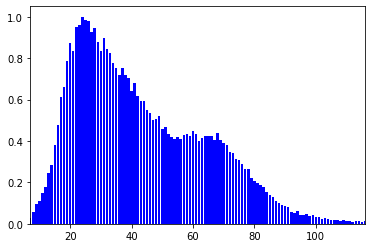

In [17]:
import matplotlib.pyplot as plt
plot_threshold = 0.01
plt.bar(list(token_lengths.keys()), token_lengths.values(), color='b')
plt.xlim([min([key for key in token_lengths.keys() if token_lengths[key] > plot_threshold]), max([key for key in token_lengths.keys() if token_lengths[key] > plot_threshold])])
plt.show()

In [18]:
MAX_TOKEN_LENGTH = 100

### Define dataset class

In [31]:
# Get distribution of classes for a given subset of the data
def get_class_dist(data, classes):
    dist = {}
    
    for c in classes:
        dist[c] = 0
    
    for i in range(data.shape[0]):
        dist[data[i]] += 1
    
    for key in dist:
        print(f"{key} = {(dist[key]/len(data))*100 : .2f} %")

In [53]:
class TweetsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        text = self.X[i]
        return {
            'text': torch.from_numpy(np.asarray(text, dtype=np.object)),
            'label': torch.tensor(y, dtype=torch.long)
        }

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [42]:
get_class_dist(y_train, {0: 'negative', 1: 'positive'})

0 =  50.30 %
1 =  49.70 %


In [43]:
get_class_dist(y_test, {0: 'negative', 1: 'positive'})

0 =  48.81 %
1 =  51.19 %


In [21]:
X_train.shape

(336, 200)

In [22]:
y_train.shape

(336,)

In [23]:
X_test.shape

(84, 200)

In [24]:
y_test.shape

(84,)

### Model

In [25]:
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 2e-5

In [51]:
num_workers = 0

train_data_loader = DataLoader(
    TweetsDataset(X_train, y_train),
    batch_size=BATCH_SIZE,
    num_workers=num_workers,
    shuffle=True
)

test_data_loader = DataLoader(
    TweetsDataset(X_test, y_test),
    batch_size=BATCH_SIZE,
    num_workers=num_workers
)

In [54]:
sample = next(iter(train_data_loader))

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found object

In [ ]:
sample.keys()
print(len(sample['text']))   
print(sample['label'])    